In [47]:
import sys
sys.path.append("../src")
import localmodule

import h5py
import librosa
import numpy as np
import os
import soundfile as sf

# Define PCEN smoother.
def pcen_smooth(melspec, time_constant_frames):
    smoothed_melspec = melspec.copy()
    coeff = 1.0 / time_constant_frames
    num_cols = melspec.shape[1]
    for col in np.arange(1, num_cols):
        smoothed_melspec[:, col] =\
            smoothed_melspec[:, col - 1] +\
            (melspec[:, col] - smoothed_melspec[:, col - 1]) * coeff
    return smoothed_melspec

unit_str = "unit02"
center_hour = 10
center_minute = 19
center_second = 4.63
snippet_duration = 10 # in s

data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
full_audio_str = "_".join([dataset_name, "full-audio"])
full_audio_dir = os.path.join(data_dir, full_audio_str)

recording_str = unit_str + ".flac"
recording_path = os.path.join(full_audio_dir, recording_str)
full_audio = sf.SoundFile(recording_path)
full_audio_length = len(full_audio)

center_timestamp = 3600 * center_hour + 60 * center_minute + center_second
begin_timestamp = center_timestamp - snippet_duration / 2
sample_rate = localmodule.get_sample_rate()
begin_sample = int(begin_timestamp * sample_rate)
full_audio.seek(begin_sample)
chunk_waveform = full_audio.read(snippet_duration * sample_rate)

logmelspec_settings = localmodule.get_logmelspec_settings()
pcen_settings = localmodule.get_pcen_settings()
chunk_waveform = librosa.resample(
    chunk_waveform, sample_rate, logmelspec_settings["sr"])
chunk_waveform = chunk_waveform * (2**32)

stft = librosa.stft(
    chunk_waveform,
    n_fft=logmelspec_settings["n_fft"],
    win_length=logmelspec_settings["win_length"],
    hop_length=logmelspec_settings["hop_length"],
    window=logmelspec_settings["window"])

# Delete last sample to compensate for padding.
stft = stft[:, :-1]

# Compute squared magnitude coefficients.
abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)

# Gather frequency bins according to the Mel scale.
melspec = librosa.feature.melspectrogram(
    y=None,
    S=abs2_stft,
    sr=logmelspec_settings["sr"],
    n_fft=logmelspec_settings["n_fft"],
    n_mels=logmelspec_settings["n_mels"],
    htk=True,
    fmin=logmelspec_settings["fmin"],
    fmax=logmelspec_settings["fmax"])

# Smooth in time.
smoothed_melspec =\
    pcen_smooth(melspec, pcen_settings["pcen_time_constant_frames"])
    
pcen_gain = (smoothed_melspec + 1) ** pcen_settings["pcen_norm_exponent"]
pcen_melspec = melspec * pcen_gain

# Raise to PCEN exponent.
pcen_offset = pcen_melspec.max() / 10.0
pcen =\
    (pcen_melspec + pcen_offset) ** pcen_settings["pcen_power"] -\
    pcen_offset ** pcen_settings["pcen_power"]

In [54]:
backgrounds_name = "_".join(
    [dataset_name, "full-pcen-backgrounds"])
backgrounds_dir = os.path.join(data_dir, backgrounds_name)
T_name = "T-1800"
T_dir = os.path.join(backgrounds_dir, T_name)
background_name = "_".join([
    dataset_name,
    "pcen-backgrounds",
    unit_str,
    "T-1800.hdf5"
])

background_path = os.path.join(T_dir, background_name)
background_file = h5py.File(background_path)
background_dataset = background_file["pcen_background"]
auxiliary_features = background_dataset[:, :, -1]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.40191817e-03,   2.51183007e-03,   2.48887762e-03, ...,
          3.40734492e-03,   1.27841311e-03,   1.19036798e-04],
       [  3.59650590e-02,   3.79688926e-02,   3.87999788e-02, ...,
          2.26071030e-02,   1.48876747e-02,   8.89007840e-03],
       ..., 
       [  7.18817413e-01,   7.34704196e-01,   7.39259481e-01, ...,
          2.31278747e-01,   1.58211321e-01,   9.48254019e-02],
       [  1.49067771e+00,   1.51058030e+00,   1.52293468e+00, ...,
          4.58218694e-01,   3.14497977e-01,   1.92511022e-01],
       [  2.93221760e+00,   2.99182105e+00,   2.99121809e+00, ...,
          7.22542465e-01,   5.08428216e-01,   3.09803367e-01]], dtype=float32)

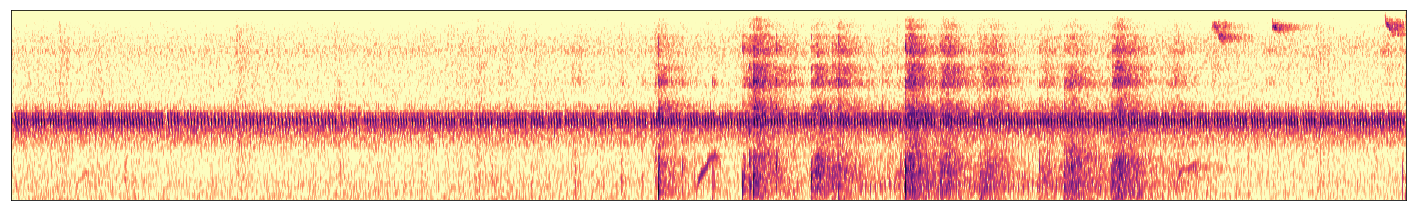

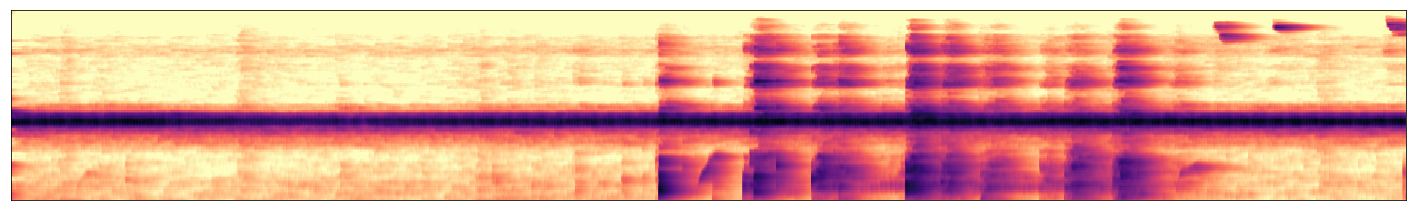

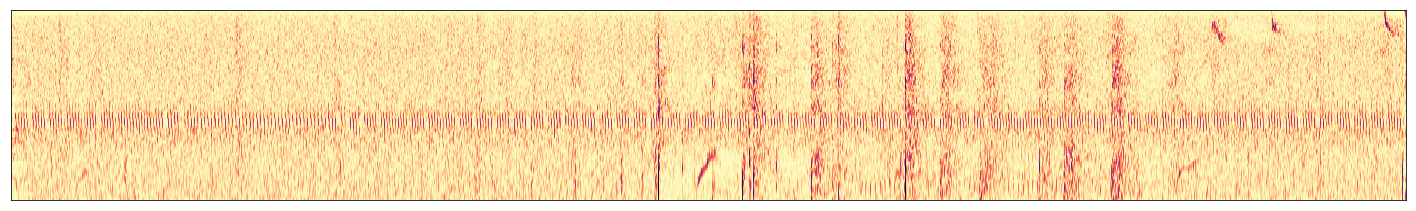

In [33]:
%matplotlib inline
from matplotlib import pyplot as plt
from librosa.display import specshow

min_db = 132

# MEL SPECTROGRAM
plt.figure(figsize=(25, 3.5))
logmelspec = librosa.logamplitude(melspec)
logmelspec = np.maximum(logmelspec, min_db)
specshow(logmelspec, cmap="magma_r")


# SMOOTHED MEL SPECTROGRAM
plt.figure(figsize=(25, 3.5))
smoothed_logmelspec = librosa.logamplitude(smoothed_melspec)
smoothed_logmelspec = np.maximum(smoothed_logmelspec, min_db)
specshow(smoothed_logmelspec, cmap="magma_r")


# PCEN
plt.figure(figsize=(25, 3.5))
log_pcen = np.log1p(pcen / 2)
specshow(log_pcen, cmap="magma_r")

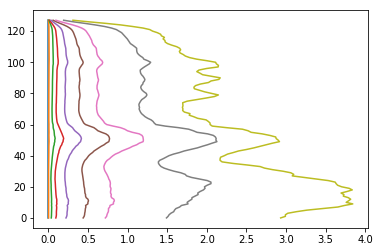

In [87]:
log_auxiliary_features = (auxiliary_features.T);
freq_range = list(range(logmelspec_settings["n_mels"]))
plt.plot(log_auxiliary_features, freq_range);


In [83]:
auxiliary_features[0,:]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)